Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='int',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [ ]:
### your code goes here, you can use training or validation data to visualize

# Custom Functions for plotting

# Function to generate image map
def generate_image_map(image_ds,batch_num=1):
  # Dictionary to store one image per label (0 to 9)
  label_image_map = {}
  # Iterate through the dataset without limiting the number of batches
  for images, labels in image_ds.skip(batch_num-1).take(batch_num):
      # Loop through each image and its corresponding label
      for image, label in zip(images.numpy(), labels.numpy()):
          # If we haven't already stored an image for this label
          if label not in label_image_map:
              label_image_map[label] = image  # Store the image with the unique label
          # Stop once we have one image for each label (0 to 9)
          if len(label_image_map) == 10:
              break  # Exit the inner loop if all 10 labels are found
      if len(label_image_map) == 10:
          break  # Exit outer loop once all labels are covered
  # Sort the dictionary by keys
  sorted_image_map=dict(sorted(label_image_map.items()))
  # Display the keys of the dictionary to check which labels have been collected
  print("Labels found:", sorted_image_map.keys())
  return sorted_image_map


# Function to plot sample images
def plot_sample_images(class_names, label_image_map):
  plt.figure(figsize=(20, 10))
  for idx, (label, image) in enumerate(label_image_map.items()):
      plt.subplot(2, 5, idx + 1)  # Create a 2x5 grid for the images
      plt.imshow(image.astype("uint8"))  # Display the image
      plt.title(f"Class: {class_names[label]}")  # Display the class name
      plt.axis('off')  # Turn off the axis
  # Show the plot with all images
  plt.tight_layout()
  plt.show()

In [ ]:
# Genarate random batch number between 0 and 10
import random
batch_num=random.randint(1,11)
batch_num

6

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


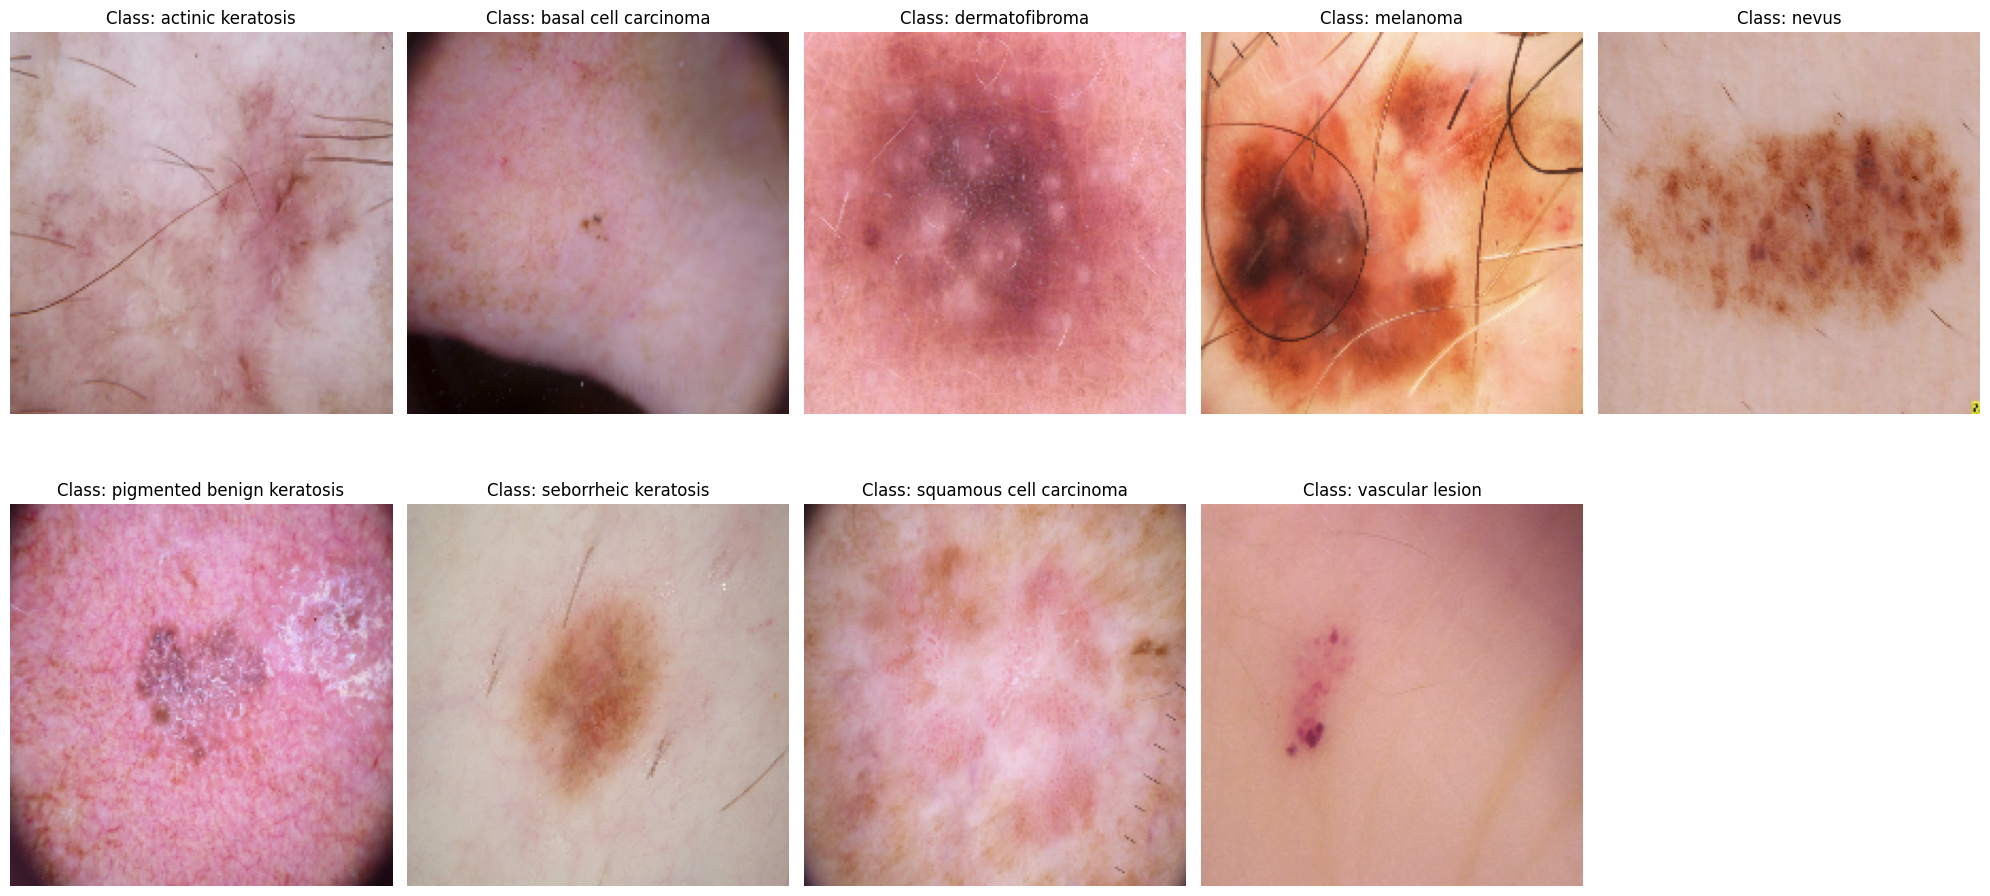

In [ ]:
# Visualize Train Data
train_image_map=generate_image_map(train_ds,batch_num)
plot_sample_images(class_names,train_image_map)

Labels found: dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


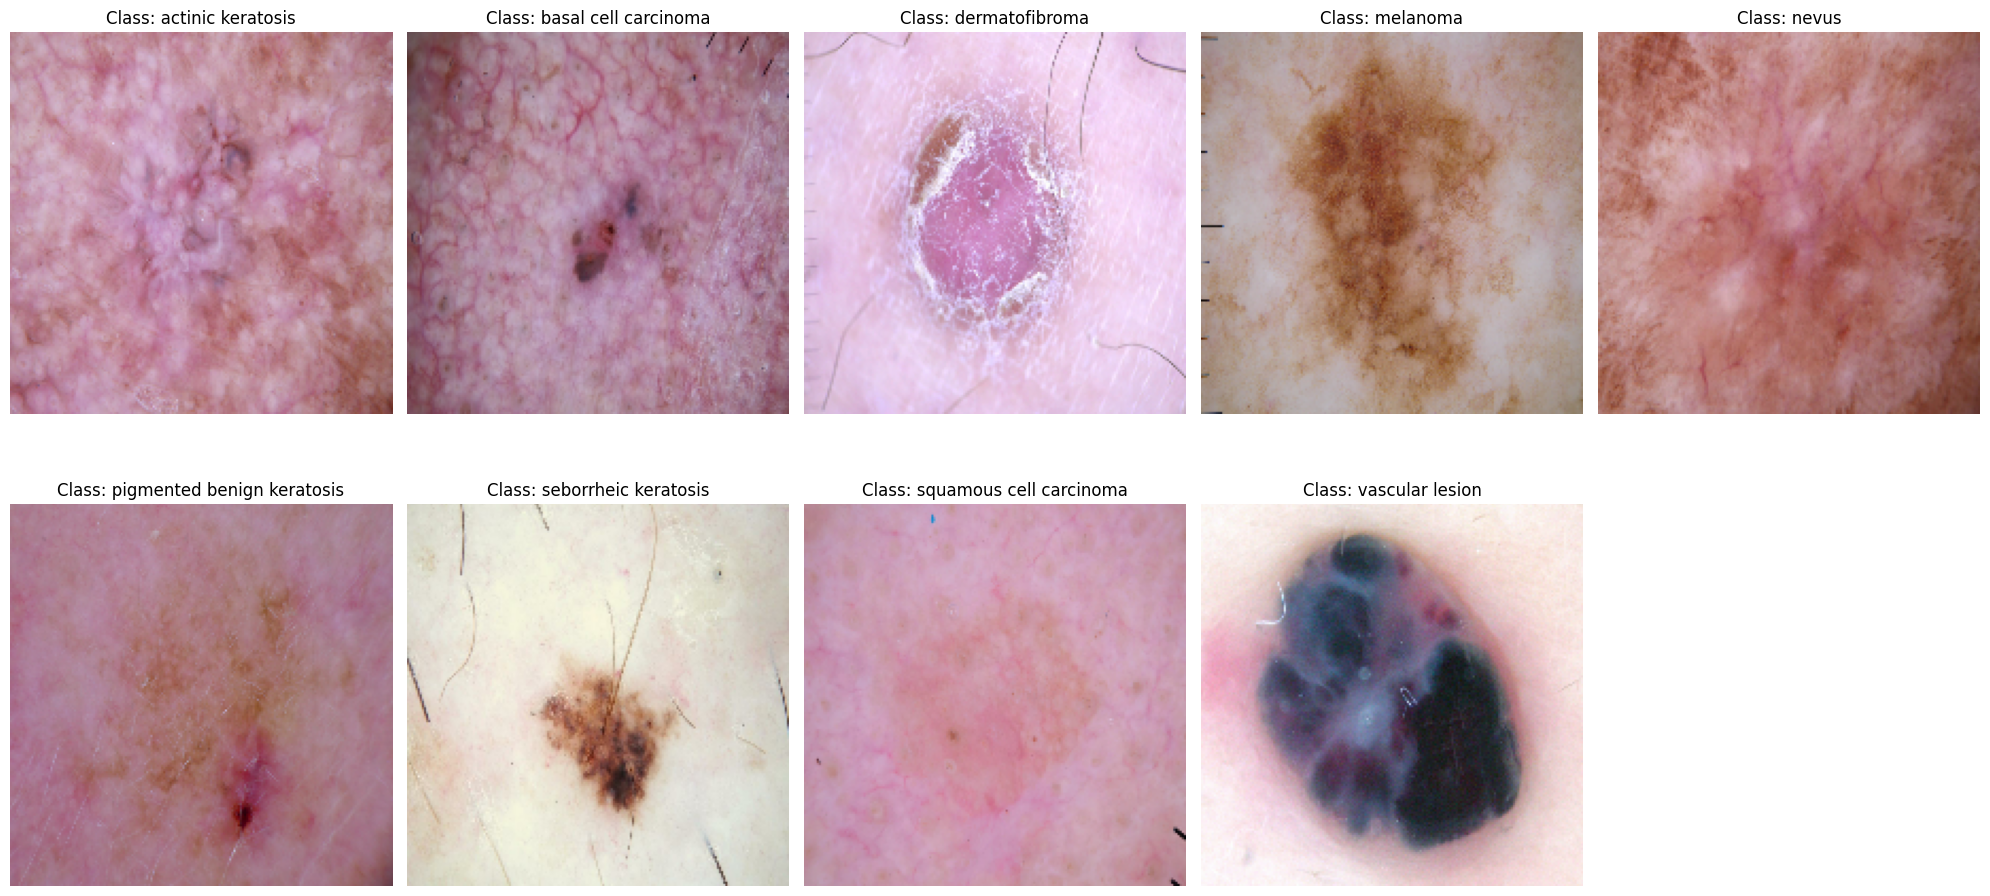

In [ ]:
# Visualize Validation Data
val_image_map=generate_image_map(val_ds,batch_num)
plot_sample_images(class_names,val_image_map)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# First Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
# Second Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_1")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 397s 514ms/step - accuracy: 0.1955 - loss: 3.3364 - val_accuracy: 0.2617 - val_loss: 1.9505
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 48s 35ms/step - accuracy: 0.3174 - loss: 1.8476 - val_accuracy: 0.4094 - val_loss: 1.6728
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3734 - loss: 1.7177 - val_accuracy: 0.4698 - val_loss: 1.5236
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4849 - loss: 1.4595 - val_accuracy: 0.5078 - val_loss: 1.4514
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5069 - loss: 1.3699 - val_accuracy: 0.5436 - val_loss: 1.3999
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5397 - loss: 1.2904 - val_accuracy: 0.5324 - val_loss: 1.4925
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5962 - loss: 1.1847 - val_accuracy: 0.5145 - val_loss: 1.4788
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6121 - loss: 1.0704 - val_accuracy: 0.4161

### Visualizing training results

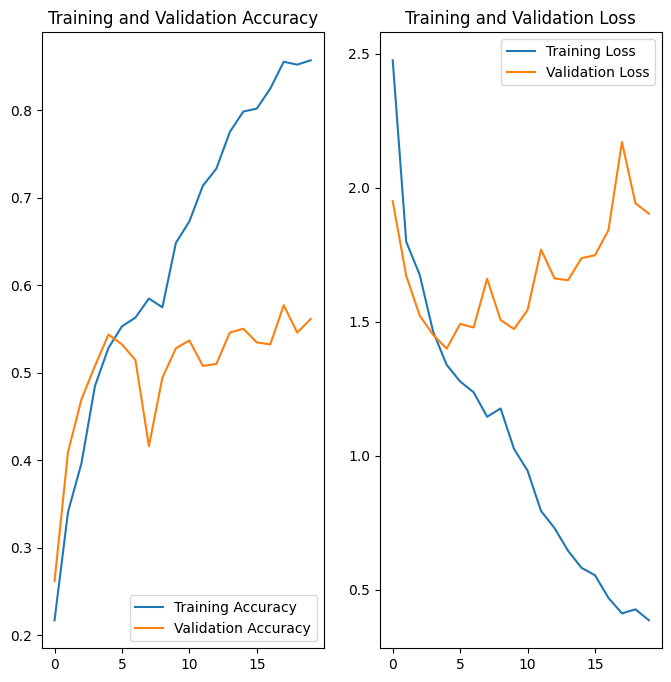

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- The training accuracy steadily improve by the 20th epoch, indicating that - the model is learning and fitting the training data well.
- The validation accuracy, on the other hand, peaks at around 55% and - then stagnates or decreases by the 20th epoch. This shows that the model - is not generalizing well to unseen data and starts to overfit after a - certain point.
- While the training loss continues to drop, the validation loss increases significantly over time by the 20th epoch.

<b><i>The model is overfitting, as indicated by the widening gap between the training and validation performance</i></b>

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical", seed=123 ),
  layers.RandomRotation(0.2, seed=123),
  layers.RandomZoom(0.2, seed=123),
] , name="Data_Augmentation_Layer")

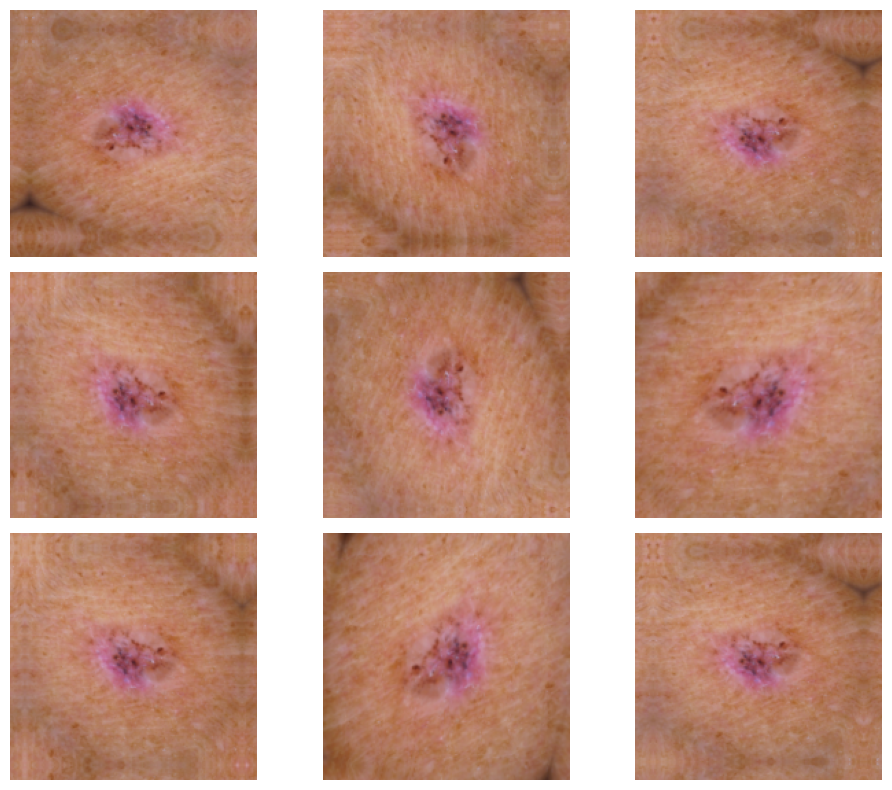

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
random_num=random.randint(1,11)
# Your code goes here
plt.figure(figsize=(10, 8))
for images, _ in train_ds.skip(random_num-1).take(random_num):
  for i in range(9):
    augmented_images = data_augmentation(images) # data augmenatation
    ax = plt.subplot(3, 3, i + 1) # Create a 3x3 grid for the images
    plt.imshow(augmented_images[random_num].numpy().astype("uint8")) # Display the image
    plt.axis("off") # Turn off the axis
# Show the plot with all images
plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
##### model=Sequential(name="Melanoma_Detection_Model2")
##### # Adding Rescaling layer
##### model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3) ,  name="Rescaling_Layer"))
##### # Adding Data Augmentation
##### model.add( data_augmentation )
##### # First Part
##### model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_1"))  # adding first Convolution layer
##### model.add(layers.BatchNormalization( name="Batch_Normalization_Layer_1" ) )# adding Batch Normalization
##### model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",name="Conv2D_Layer_2") )# adding second Convolution layer
##### model.add(layers.BatchNormalization( name="Batch_Normalization_Layer_2" ))# adding Batch Normalization
##### model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
##### model.add(layers.Dropout(0.30 ,name="Dropout_1") )# adding dropouts
##### # Second Part
##### model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_3")) # adding third Convolution layer
##### model.add(layers.BatchNormalization( name="Batch_Normalization_Layer_3" ))# adding Batch Normalization
##### model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_4")) # adding fourth Convolution layer
##### model.add(layers.BatchNormalization( name="Batch_Normalization_Layer_4" ))# adding Batch Normalization
##### model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
##### model.add(layers.Dropout(0.30 ,name="Dropout_2") )# adding dropouts
##### # Flattening the output
##### model.add(layers.Flatten(name="Flatten_Layer"))
##### # Fully Connected Layer
##### model.add(layers.Dense(units=256,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
##### model.add(layers.Dropout(0.50 ,name="Dropout_4")) # increase dropout slightly - adding dropouts
##### # Output Layer
##### model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
##### model=Sequential(name="Melanoma_Detection_Model")
##### # Adding Rescaling layer
##### model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
##### # Adding Data Augmentation
##### model.add( data_augmentation )
##### # First Part
##### model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
##### model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",name="Conv2D_Layer_2") )# adding second Convolution layer
##### model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
##### model.add(layers.Dropout(0.20 ,name="Dropout_1") )# adding dropouts
##### # Second Part
##### model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_3")) # adding third Convolution layer
##### model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_4")) # adding fourth Convolution layer
##### model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
##### model.add(layers.Dropout(0.20 ,name="Dropout_2") )# adding dropouts
##### # Flattening the output
##### model.add(layers.Flatten(name="Flatten_Layer"))
##### # Fully Connected Layer
##### model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
##### model.add(layers.Dropout(0.35,name="Dropout_3")) # adding dropouts
##### # Output Layer
##### model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here
model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# Adding Data Augmentation
model.add( data_augmentation )
# First Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_1") )# adding dropouts
# Second Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_2") )# adding dropouts
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_3")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.1445 - loss: 4.2056 - val_accuracy: 0.2192 - val_loss: 2.0684
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.2919 - loss: 1.9372 - val_accuracy: 0.3937 - val_loss: 1.7612
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.3950 - loss: 1.6765 - val_accuracy: 0.3624 - val_loss: 1.9168
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3718 - loss: 1.7358 - val_accuracy: 0.3468 - val_loss: 1.8290
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.4099 - loss: 1.6321 - val_accuracy: 0.4072 - val_loss: 1.7984
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4136 - loss: 1.5973 - val_accuracy: 0.4586 - val_loss: 1.6714
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.4520 - loss: 1.5218 - val_accuracy: 0.4497 - val_loss: 1.5870
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.4658 - loss: 1.4985 - val_accuracy: 0.4676 - v

### Visualizing the results

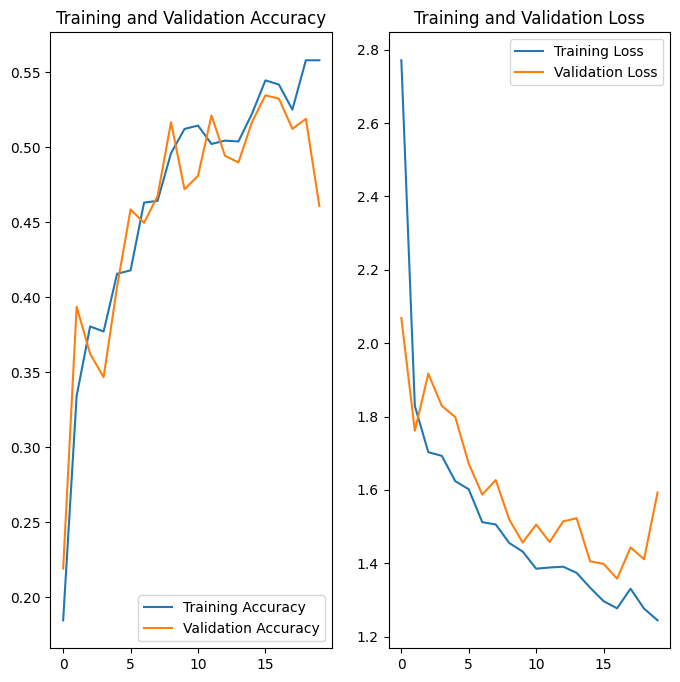

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
list_images = []
for i in class_names:
    list_images.append(len(list(data_dir_train.glob(i+'/*.jpg'))))

data = {'Class Names': class_names, 'Image Count': list_images}
original_df = pd.DataFrame(data)

In [ ]:
original_df.head(9)

Class Names  Image Count
0           actinic keratosis          114
1        basal cell carcinoma          376
2              dermatofibroma           95
3                    melanoma          438
4                       nevus          357
5  pigmented benign keratosis          462
6        seborrheic keratosis           77
7     squamous cell carcinoma          181
8             vascular lesion          139

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Answer - seborrheic keratosis has the least number of samples - 77
#### - Which classes dominate the data in terms proportionate number of samples?
Answer - pigmented benign keratosis dominates the data in terms proportionate number of samples - 462


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D67765F3640>: 100%|██████████| 500/500 [00:27<00:00, 17.90 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D677662FD90>: 100%|██████████| 500/500 [00:19<00:00, 25.08 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6774E4B4F0>: 100%|██████████| 500/500 [00:22<00:00, 22.55 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D6767F33D90>: 100%|██████████| 500/500 [01:33<00:00,  5.37 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=724x542 at 0x7D6767F71EA0>: 100%|██████████| 500/500 [01:18<00:00,  6.41 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D6767F7FD00>: 100%|██████████| 500/500 [00:19<00:00, 25.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7D6767F326E0>: 100%|██████████| 500/500 [00:44<00:00, 11.13 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D67741E08B0>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D67741F9630>: 100%|██████████| 500/500 [00:20<00:00, 24.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0028714.jpg_403b57e0-07e1-419d-b5aa-f519ab581b12.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0026876.jpg_65ed8037-c6b2-4950-9202-5a0a5c8d142a.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0029448.jpg_b0d19c34-59fa-454f-9193-d81c79af8516.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output/vascular lesion_original_ISIC_0033135.jpg_8f278a20-874f-46e4-bd70-d890aab2430d.jpg',
 '/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin c

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',
 'vascular lesion',


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2],ignore_index=True)

In [ ]:
new_df['Label'].value_counts()

NameError: name 'new_df' is not defined

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/AI_ML_DS/Google_Colab_Workspace/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

NameError: name 'tf' is not defined

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model=Sequential(name="Melanoma_Detection_Model")
# Adding Rescaling layer
model.add(layers.Rescaling(1.0/255.0 , offset=0.0 , input_shape=(img_height,img_width,3), name="Rescaling_Layer"))
# Adding Data Augmentation
model.add( data_augmentation )
# First Part
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding="same",activation="relu",  name="Conv2D_Layer_1"))  # adding first Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_1")) # adding first Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_1") )# adding dropouts
# Second Part
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu", name="Conv2D_Layer_2")) # adding second Convolution layer
model.add(layers.MaxPooling2D(pool_size=(2,2), name="MaxPooling2D_Layer_2")) # adding second Max Pooling layer
model.add(layers.Dropout(0.20 ,name="Dropout_2") )# adding dropouts
# Flattening the output
model.add(layers.Flatten(name="Flatten_Layer"))
# Fully Connected Layer
model.add(layers.Dense(units=128,activation="relu",name="FC_Layer_1") )# adding first fully connected layer
model.add(layers.Dropout(0.20,name="Dropout_3")) # adding dropouts
# Output Layer
model.add(layers.Dense(units=len(class_names),activation="softmax",name="Output_Layer")) # adding output layer

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "Melanoma_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Rescaling_Layer (Rescaling)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Data_Augmentation_Layer (Sequential) │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_1 (Conv2D)              │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_1 (MaxPooling2D)  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_Layer_2 (Conv2D)              │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPooling2D_Layer_2 (MaxPooling2D)  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten_Layer (Flatten)              │ (None, 129600)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_Layer_1 (Dense)                   │ (None, 128)                 │      16,588,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,609,481 (63.36 MB)

 Trainable params: 16,609,481 (63.36 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [ ]:
epochs = 30
steps_per_epoch = len(train_ds) // batch_size
validation_steps = len(val_ds) // batch_size
## Your code goes here, use 30 epochs.
history = model.fit(train_ds ,
                    batch_size=batch_size ,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1)

NameError: name 'train_ds' is not defined

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

